In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import re
import random
plt.style.use('ggplot')
%matplotlib inline

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
english_stemmer=SnowballStemmer('english')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

/Users/rajegupt/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda

from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [3]:
# Pick randomly 20000 reviews

n = 413000  
s = 20000 
skip = sorted(random.sample(range(1,n),n-s))

df = pd.read_csv("Amazon_Unlocked_Mobile.csv", skiprows=skip)
#df = pd.read_csv("Amazon_Unlocked_Mobile.csv")

In [4]:
df.shape

(20840, 6)

In [5]:
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""Nokia Asha 302 Unlocked GSM Phone with 3.2MP ...",Nokia,299.0,5,Very practical and user-friendly phone. I am v...,0.0
1,"""Nokia Asha 302 Unlocked GSM Phone with 3.2MP ...",Nokia,299.0,5,Bought this as an alternative to a smart phone...,1.0
2,"""Nokia Asha 302 Unlocked GSM Phone with 3.2MP ...",Nokia,299.0,5,solid phone,0.0
3,"""Nokia Asha 302 Unlocked GSM Phone with 3.2MP ...",Nokia,299.0,5,Nokia Asha 302 Unlocked GSM Phone with 3.2MP C...,13.0
4,"""Nokia Asha 302 Unlocked GSM Phone with 3.2MP ...",Nokia,299.0,5,We just received the phone a few days ago. Put...,3.0


In [6]:
data= df[['Reviews','Rating']]

In [7]:
data.isnull().any()

Reviews     True
Rating     False
dtype: bool

In [8]:
data.isnull().values.sum()

4

In [9]:
data = data[data['Reviews'].isnull()==False]

In [10]:
#df=df.dropna()
data.shape

(20836, 2)

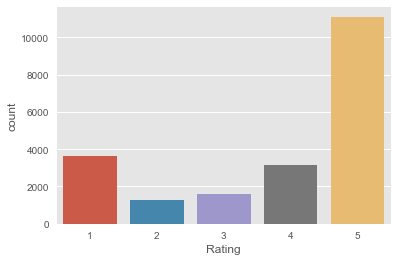

In [11]:
sns.countplot(data['Rating'])

In [12]:
print (data[data['Rating']==5].count())
print (data[data['Rating']<5].count())

Reviews    11115
Rating     11115
dtype: int64
Reviews    9721
Rating     9721
dtype: int64


### Apply LSTM

In [13]:
train, test = train_test_split(data, test_size = 0.3)

In [14]:
max_features=20000
EMBEDDING_DIM=100
VALIDATION_SPLIT=0.2
maxlen= 80
batch_size=32
nb_classes=5

In [15]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words= max_features)
tokenizer.fit_on_texts(train['Reviews'])
sequences_train = tokenizer.texts_to_sequences(train['Reviews'])
sequences_test = tokenizer.texts_to_sequences(test['Reviews'])

/Users/rajegupt/anaconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [41]:
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)

Pad sequences (samples x time)


In [44]:
X_train

array([[   0,    0,    0, ...,   69,    6, 2690],
       [1961,  400,    8, ...,  545,    1,  757],
       [ 244,  250,  164, ...,  164,   53,  193],
       ..., 
       [   0,    0,    0, ...,    6,  378, 3924],
       [   0,    0,    0, ...,   52,   14,  126],
       [   0,    0,    0, ...,   64,    4,  100]], dtype=int32)

In [49]:
Y_train = np_utils.to_categorical(train['Rating']-1, nb_classes)
Y_test = np_utils.to_categorical(test['Rating']-1, nb_classes)


In [51]:
print ("Building the model")

model = Sequential()
model.add(Embedding(max_features, 128, dropout=0.2))
model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy', optimizer= 'adam', 
              metrics=['accuracy'])

print ('Training the model')
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1,
         validation_data = (X_test, Y_test))

score, acc = model.evaluate(X_test, Y_test, batch_size= batch_size)

print ("Test Score:", score)
print ("Test Accuracy:", acc)

print ("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

Building the model


/Users/rajegupt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
/Users/rajegupt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`


Training the model


/Users/rajegupt/anaconda3/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 14585 samples, validate on 6251 samples
Epoch 1/1
6251/6251 [==============================] - 12s     

In [52]:
print('prediction accuracy: ', accuracy_score(test['Rating'], preds+1))

prediction accuracy:  0.682450807871
